### Import 3rd libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import tensorflow as tf
tf.__version__

'2.4.1'

In [3]:
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import metrics

### Hyper Parameters

In [15]:
MAX_SENTENCE_LENGTH = 300
vocab_size = 10000
num_oov_buckets = 1000
d_model = 128
dropout_rate = 0.3
gru_units = 128

### Download IMDB Review dataset

In [5]:
import tensorflow_datasets as tfds
datasets, info = tfds.load("imdb_reviews", as_supervised=True, with_info=True)
train_size = info.splits["train"].num_examples

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete92H1O9/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete92H1O9/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete92H1O9/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


## Prepare Our dataset

#### Preprocess batches
Convert batches to tokens of words

In [6]:
def preprocess(X_batch, y_batch):
  X_batch = tf.strings.substr(X_batch, 0, MAX_SENTENCE_LENGTH)
  X_batch = tf.strings.regex_replace(X_batch, b"<br\\s*/?>", b" ")
  X_batch = tf.strings.regex_replace(X_batch, b"[^a-zA-Z']", b" ")
  X_batch = tf.strings.split(X_batch)
  X_batch = X_batch.to_tensor(default_value=b"<pad>")
  y_batch = tf.cast(y_batch,'float32')
  return X_batch,y_batch

#### Create a vocabulary for dataset

In [7]:
from collections import Counter
vocabulary = Counter()
for X_batch, y_batch in datasets["train"].batch(32).map(preprocess):
  for review in X_batch:
    vocabulary.update(list(review.numpy()))

In [8]:
vocabulary.most_common(10)

[(b'<pad>', 214309),
 (b'the', 61137),
 (b'a', 38564),
 (b'of', 33983),
 (b'and', 33431),
 (b'to', 27707),
 (b'I', 27019),
 (b'is', 25719),
 (b'in', 18966),
 (b'this', 18490)]

In [9]:
truncated_vocabulary = [word for word, count in vocabulary.most_common()[:vocab_size]]

#### Create Look up table for vocabulary

In [10]:
words = tf.constant(truncated_vocabulary)
word_ids = tf.range(len(truncated_vocabulary), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [11]:
table.lookup(tf.constant([b"This movie was faaaaaantastic".split()]))

<tf.Tensor: shape=(1, 4), dtype=int64, numpy=array([[   22,    12,    11, 10053]])>

In [12]:
table.lookup(tf.constant([b"This movie was faaaaaantastic <pad>".split()]))

<tf.Tensor: shape=(1, 5), dtype=int64, numpy=array([[   22,    12,    11, 10053,     0]])>

In [13]:
def encode_words(X_batch, y_batch):
  return table.lookup(X_batch), y_batch

#### Our Final model

In [14]:
train_set = datasets["train"].batch(32).map(preprocess,num_parallel_calls=-1)
train_set = train_set.map(encode_words).prefetch(1)

test_set = datasets['test'].batch(252).map(preprocess,num_parallel_calls=-1)
test_set = test_set.map(encode_words).prefetch(1)

## Create two layer GRU

In [20]:
model = models.Sequential(
    [
     layers.Embedding(table.size(),d_model),
     layers.GRU(units=gru_units,dropout=dropout_rate,return_sequences=True),
     layers.GRU(units=gru_units,dropout=dropout_rate,),
     layers.Dense(1,'sigmoid')
    ]
)

In [21]:
EPOCHS = 20

optimizer = optimizers.Adam()
cb = [
      callbacks.EarlyStopping(patience=4,restore_best_weights=True,),
      callbacks.ReduceLROnPlateau(patience=2,factor=0.5,min_lr=1e-4)
]

model.compile(optimizer,losses.binary_crossentropy,['acc'])

In [22]:
history = model.fit(train_set,epochs=EPOCHS,validation_data=test_set,callbacks=cb)

Epoch 1/20
782/782 [==============================] - 56s 28ms/step - loss: 0.6619 - acc: 0.5577 - val_loss: 0.4836 - val_acc: 0.7637
Epoch 2/20
782/782 [==============================] - 21s 27ms/step - loss: 0.4218 - acc: 0.8108 - val_loss: 0.4905 - val_acc: 0.7695
Epoch 3/20
782/782 [==============================] - 21s 27ms/step - loss: 0.2788 - acc: 0.8893 - val_loss: 0.5971 - val_acc: 0.7547
Epoch 4/20
782/782 [==============================] - 21s 27ms/step - loss: 0.1793 - acc: 0.9359 - val_loss: 0.6898 - val_acc: 0.7543
Epoch 5/20
782/782 [==============================] - 22s 27ms/step - loss: 0.1242 - acc: 0.9597 - val_loss: 0.8462 - val_acc: 0.7421


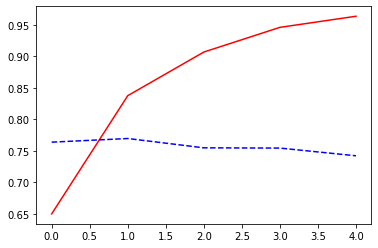

In [23]:
plt.plot(history.epoch,history.history['acc'],'r-')
plt.plot(history.epoch,history.history['val_acc'],'b--')